In [73]:
import bt
import talib
import pandas_datareader.data as pdd
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
# get data from yahoo
df = pdd.DataReader('SPY', 'yahoo', start='2011-09-10', end='2022-10-10')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-09-09,119.059998,115.279999,117.680000,115.919998,380195100.0,93.539474
2011-09-12,116.760002,114.050003,114.470001,116.669998,305793500.0,94.144676
2011-09-13,118.180000,116.220001,117.050003,117.739998,272514700.0,95.008064
2011-09-14,120.800003,116.720001,118.339996,119.370003,319389500.0,96.323402
2011-09-15,121.470001,119.400002,120.650002,121.430000,326777200.0,97.985680


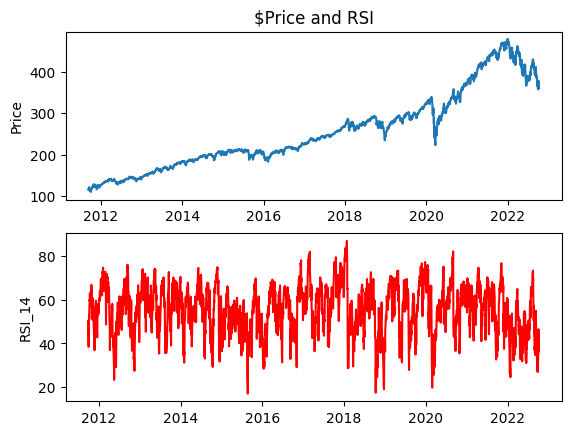

In [95]:
# build signal
df.describe()
df['RSI_14'] = talib.RSI(df['Close'])

# plot ADX 
fig, (ax1, ax2) = plt.subplots(2)
# Plot ADX with the price
ax1.set_ylabel('Price')
ax1.plot(df['Close'])
ax2.set_ylabel('RSI_14')
ax2.plot(df['RSI_14'], color='red')

ax1.set_title('$Price and RSI')
plt.show()

In [96]:
# Add another signal
from numpy import sign


EMA_short = talib.EMA(df['Close'], timeperiod=10).to_frame()
EMA_long = talib.EMA(df['Close'],  timeperiod=50).to_frame()

# Construct the signal
signal = EMA_long.copy()
signal[EMA_long.isnull()] = 0
signal[EMA_short > EMA_long] = 1
signal[EMA_short < EMA_long] = -1
df['sma_signal'] = signal


# plot ADX 
#fig, (ax1, ax2) = plt.subplots(2)
# Plot ADX with the price
#ax1.set_ylabel('Price')
#ax1.plot(df['Close'])
#ax2.set_ylabel('RSI_14')
#ax2.plot(df['RSI_14'], color='red')

#ax1.set_title('$Price and RSI')
#plt.show()


df.tail

<bound method NDFrame.tail of                   High         Low        Open       Close       Volume  \
Date                                                                      
2011-09-09  119.059998  115.279999  117.680000  115.919998  380195100.0   
2011-09-12  116.760002  114.050003  114.470001  116.669998  305793500.0   
2011-09-13  118.180000  116.220001  117.050003  117.739998  272514700.0   
2011-09-14  120.800003  116.720001  118.339996  119.370003  319389500.0   
2011-09-15  121.470001  119.400002  120.650002  121.430000  326777200.0   
...                ...         ...         ...         ...          ...   
2022-10-04  378.000000  366.570007  372.399994  377.970001  103602800.0   
2022-10-05  379.459991  370.950012  373.390015  377.089996   88065700.0   
2022-10-06  378.720001  372.679993  375.619995  373.200012   82333500.0   
2022-10-07  373.290009  360.940002  368.970001  362.790009  107680800.0   
2022-10-10  364.209991  357.670013  363.959991  360.019989   76042800.

In [97]:
df = df.dropna()

/Users/lxc/Library/Caches/pypoetry/virtualenvs/financial-notebooks-OhKoW-Jr-py3.10/lib/python3.10/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
/Users/lxc/Library/Caches/pypoetry/virtualenvs/financial-notebooks-OhKoW-Jr-py3.10/lib/python3.10/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)


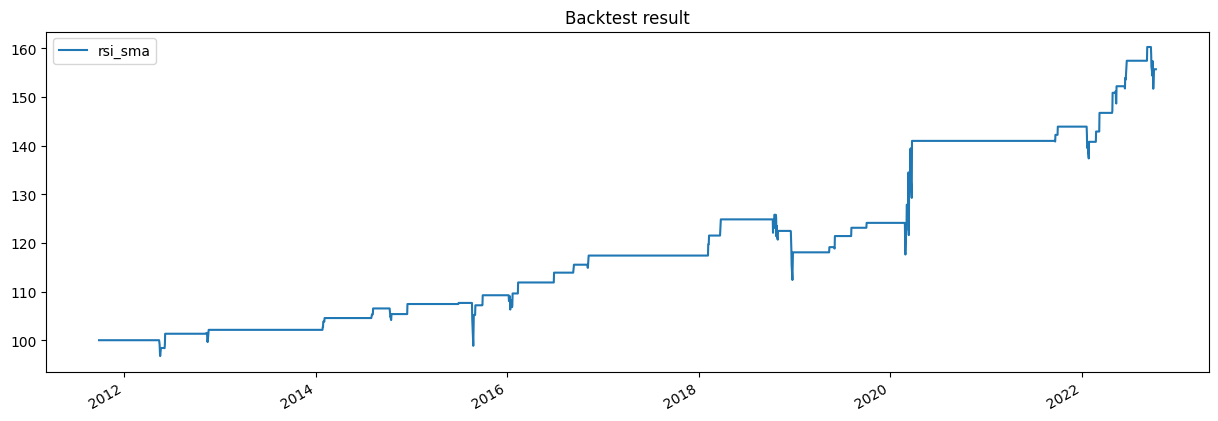

In [104]:
# backtesting
price_data = df[['Close']]

pred = (df['RSI_14'] < 35).to_frame()
pred = pred.rename(columns={"RSI_14":"Close"})

bt_strategy = bt.Strategy('rsi_sma', 
                          [bt.algos.SelectWhere(pred),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])
# Return the backtest
bt_backtest = bt.Backtest(bt_strategy, price_data)
bt_result = bt.run(bt_backtest)

bt_result.plot(title='Backtest result')
plt.show()

/Users/lxc/Library/Caches/pypoetry/virtualenvs/financial-notebooks-OhKoW-Jr-py3.10/lib/python3.10/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)


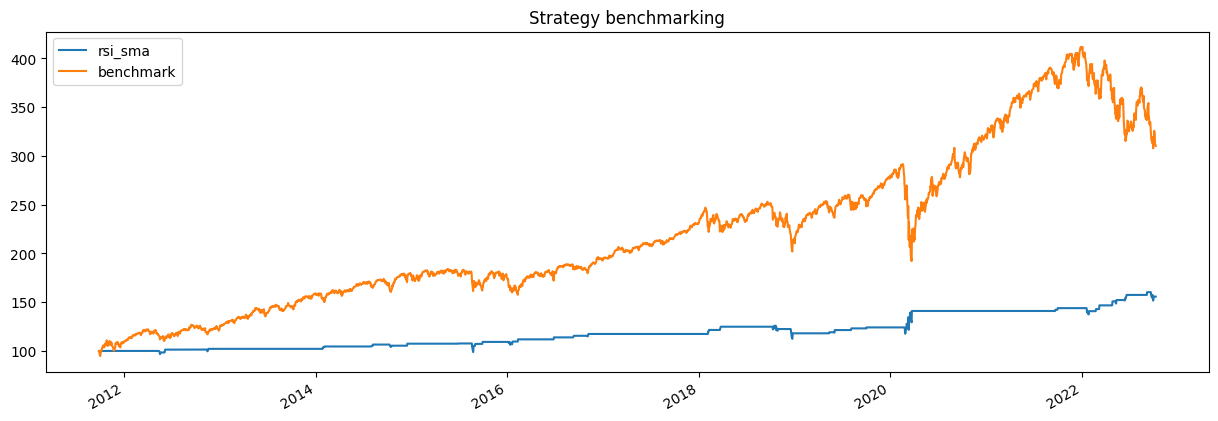

In [105]:
def buy_and_hold(price_data, name):
    # Define the benchmark strategy
    bt_strategy = bt.Strategy(name, 
                              [bt.algos.RunOnce(),
                               bt.algos.SelectAll(),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
    # Return the backtest
    return bt.Backtest(bt_strategy, price_data)

# Create benchmark strategy backtest
benchmark = buy_and_hold(price_data, name='benchmark')

# Run all backtests and plot the resutls
bt_results = bt.run(bt_backtest, benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()